## Importing Libraries

In [ ]:
%pip install git+https://github.com/AIcrowd/coco.git#subdirectory=PythonAPI

  Cloning https://github.com/AIcrowd/coco.git to /tmp/pip-req-build-j6nl56q_
  Running command git clone -q https://github.com/AIcrowd/coco.git /tmp/pip-req-build-j6nl56q_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263859 sha256=f0176a7d00e1e597f49857ba2d8f408ae5223c48c95d653fee44ccc27ce5bd9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-98h43b7m/wheels/ab/90/04/967e938726d585d7f0cdf0522611965b7e138f6cd9a6937b35
Successfully built pycocotools


In [ ]:
%pip install -U --pre segmentation-models

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.7/dist-packages (1.0.1)


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
import tensorflow as tf

from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, ZeroPadding2D, Add
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

from tensorflow.keras.activations import softmax
from typing import Callable, Union

import segmentation_models as sm

from google.colab import drive

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

import random

import cv2

import skimage.io as io

from pycocotools import mask as cocomask

import os

drive.mount('/content/drive')

Segmentation Models: using `tf.keras` framework.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

In [ ]:
from pycocotools.coco import COCO

#Loading the coco annotations
folder_loc = "/content/drive/MyDrive/Food_recognition"


coco_train = COCO(folder_loc + '/train/annotations.json')
coco_val = COCO(folder_loc + '/val/annotations.json')


loading annotations into memory...
Done (t=1.91s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


## Exploring the data

In [ ]:
def plot_image(image_id, coco, mode='train'):
    #read the image
    img = coco.loadImgs(image_id)[0]
    image = mpimg.imread(folder_loc + '/' + mode + '/images/' + img['file_name'])
    
    #display image
    img_plot = plt.imshow(image)
    
    #loading image id
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))

    for i in range(len(annotations)):
        #different color for different annotations
        colors = ['b', 'c', 'r', 'g', 'm', 'y', 'k'][i]
        ann = annotations[i]

        #plotting segmentation
        for seg in ann['segmentation']:
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.4)
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.8)
  
    #show results
    plt.show()

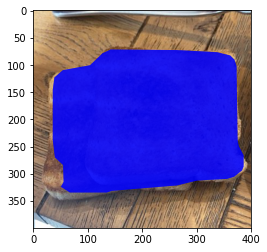

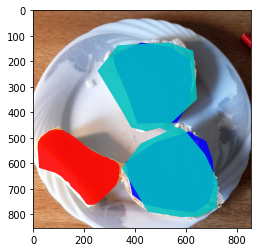

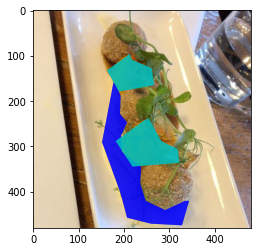

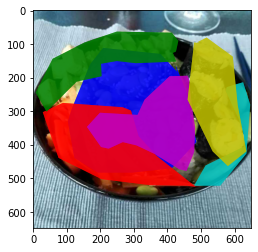

In [ ]:
#Plotting a few random images

np.random.seed(100)
img_num = []
rand = np.random.randint(0, len(coco_train.getImgIds()), 4)
for i in rand:
    img_num.append(coco_train.getImgIds()[i])
for ids in img_num:
    plot_image(ids, coco_train)

## Loading and cleaning the data

In [ ]:
def get_ordered_ids():
    catIds_raw = coco_train.getCatIds()
    catIds = []
    for cat in catIds_raw:
          catIds.append([len(coco_train.getImgIds(catIds=cat)), cat])
    catIds.sort()
    cat_ids = [cat_num[1] for cat_num in catIds ]
    return cat_ids

In [ ]:
# display COCO categories
categories = coco_train.loadCats(get_ordered_ids())
classes=[cat['name'] for cat in categories]
number_of_classes = len(classes)
print('COCO categories: ', number_of_classes)

COCO categories:  273


## Defining functions to manage the dataset

Function to filter the dataset

In [ ]:
def filterDataset(folder, mode, classes=None):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}/annotations.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []

    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
      imgIds = coco.getImgIds()
      images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

Functions to create the masks

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        #Assign to the pixel the value of the class
        pixel_value = classes.index(className)+1
        #The annToMask method returns a binary mask. 
        #Multipling the mask of that class by the pixel_value we assign that value to each of the pixels  
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        #With np.maximum we join all the masks of different classes into a single one
        #The classes are sorted by popularity in descending order, so the mask of the most popular classes will prevail on the others
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

def getBinaryMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    n_classes = len(classes) + 1
    train_mask = np.zeros((input_image_size[0], input_image_size[1], n_classes))
    for i in range(len(anns)):
        #Get the index of the class
        className = getClassName(anns[i]['category_id'], cats)
        class_index = classes.index(className) + 1

        #If the index of the class is equal to the index iterating through the annotation add the
        #binary mask to the array
        
        new_mask = cv2.resize(coco.annToMask(anns[i]), input_image_size)
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0
        train_mask[:,:,class_index] = new_mask

    #Adding background mask into the training mask in position 0
    food_mask = np.argmax(train_mask, axis=2)
    background_mask = (np.logical_not(food_mask)).astype(int)
    train_mask[:,:,0] = background_mask
    
    return train_mask

Data generators

In [ ]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size, batch_size, mode, mask_type):
    
    img_folder = '{}/{}/images'.format(folder, mode)
    dataset_size = len(images)
    #catIds = get_category_ids()
    catIds = coco.getCatIds(catNms=classes)
    n_classes = len(classes) + 1
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        #mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], n_classes)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, classes, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [ ]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)

    n_classes = len(classes) + 1
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)
        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                final_mask = np.zeros((input_image_size[0], input_image_size[1]))
                for i in range(1, n_classes):
                    color = i + 1
                    new_mask = mask[j][:,:,i]*color
                    final_mask = np.maximum(new_mask, final_mask)
                ax.imshow(final_mask);
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

## Filtering the dataset and defining the generators

In [ ]:
classes = ['water', 'bread-white', 'salad-leaf-salad-green', 'tomato', 'butter', 'bread-wholemeal', 'carrot', 'rice', 'egg', 'mixed-vegetables', 'wine-red', 'apple', 'jam', 'potatoes-steamed', 'banana', 'cheese']
images_train, dataset_size_train, coco_train = filterDataset(folder_loc,'train',classes)

loading annotations into memory...
Done (t=1.92s)
creating index...
index created!


In [ ]:
images_val, dataset_size_val, coco_val = filterDataset(folder_loc,'val',classes)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [ ]:
print("The training set size is:", dataset_size_train)
print("The validation set size is:", dataset_size_val)

The training set size is: 10454
The validation set size is: 539


In [ ]:
batch_size = 8
input_image_size = (256,256)
mask_type = 'binary'

train_gen = dataGeneratorCoco(images_train, classes, coco_train, folder_loc,
                            input_image_size, batch_size, 'train', mask_type)

val_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc,
                            input_image_size, batch_size, 'val', mask_type)

## Display binary masks

In [ ]:
def display_binary_masks(mask):
  
  n_classes = len(classes) + 1
  plt.figure(figsize=(25, 5))
  display_classes = ['background'] + classes

  for i in range(n_classes):
      color = i + 1
      new_mask = mask[:,:,i]*color
      plt.subplot(2,9,i+1)
      plt.title(display_classes[i])
      plt.axis('off')
      plt.imshow(new_mask)

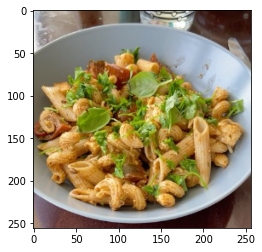

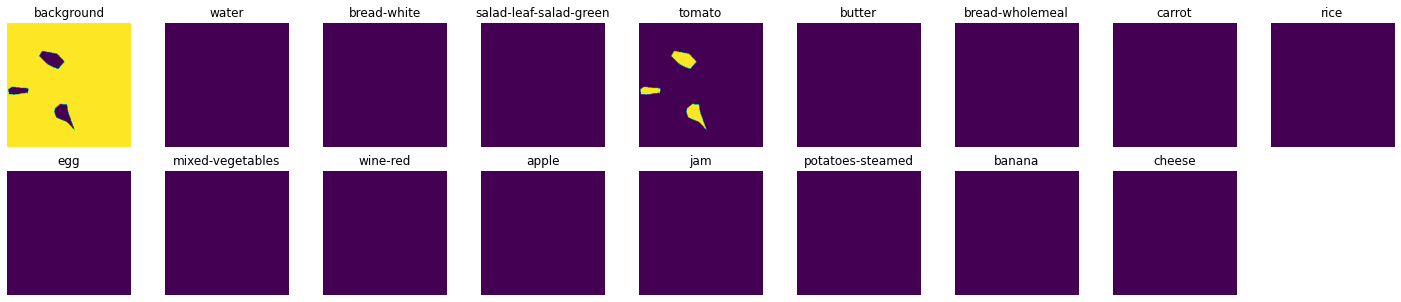

In [ ]:
image_id = 11
img_folder = '{}/{}/images'.format(folder_loc, 'train')
train_img = getImage(images_train[image_id], img_folder, input_image_size)
catIds = coco_train.getCatIds(catNms=classes)
mask = getBinaryMask(images_train[image_id], classes, coco_train, catIds, input_image_size)
plt.imshow(train_img)
display_binary_masks(mask)

## Visualize the masks


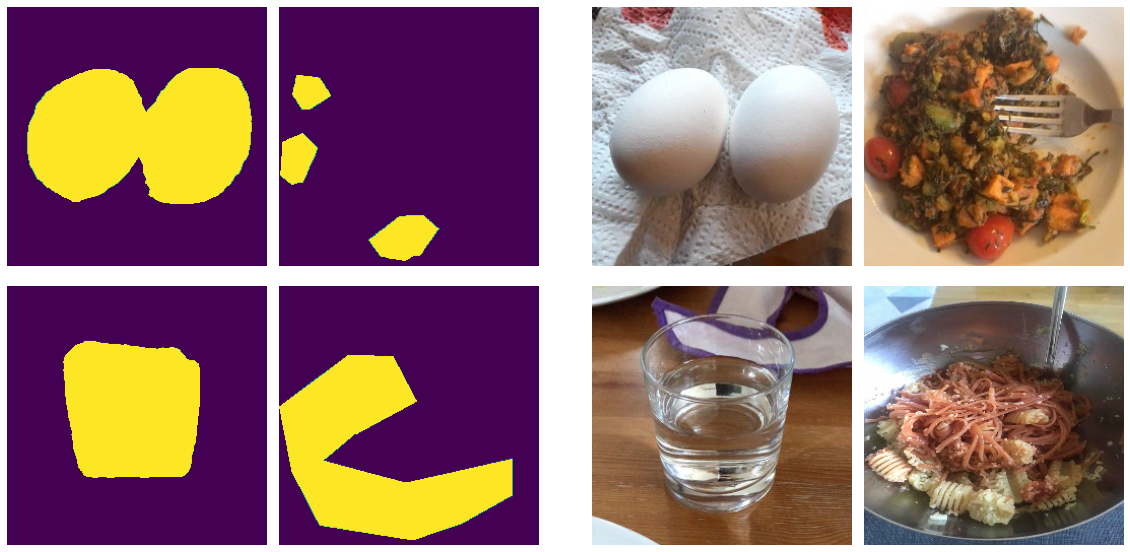

In [ ]:
visualizeGenerator(train_gen)

In [ ]:
img, mask = next(train_gen)
print("The shape of the image batch is: ", img.shape)
print("The shape of the mask batch is: ", mask.shape)

The shape of the image batch is:  (8, 256, 256, 3)
The shape of the mask batch is:  (8, 256, 256, 17)


## Data augmentation

In [ ]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    for img, mask in gen:

        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)

        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [ ]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

train_gen_aug = augmentationsGenerator(train_gen, augGeneratorArgs)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 256, 256, 17) (17 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


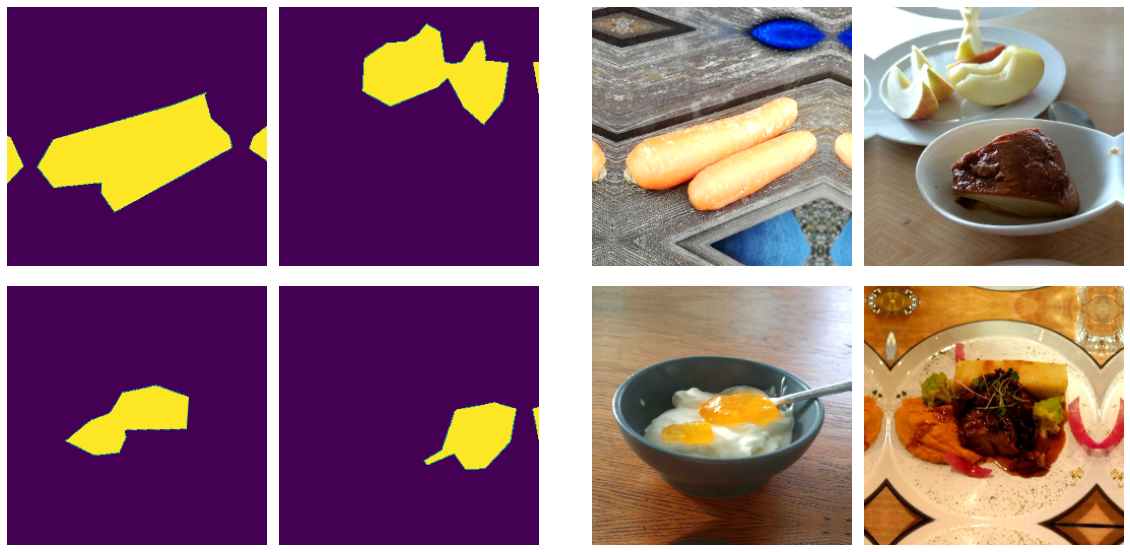

In [ ]:
visualizeGenerator(train_gen_aug)

## Building model architecture

Definition of the Link

In [ ]:
def _link(input, residual):
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]
    link = input
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        link = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([link, residual])

Definition of the encoder and decoder blocks

In [ ]:
def encoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_1 = _link(input_tensor, x)

    x = BatchNormalization()(added_1)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_2 = _link(added_1, x)

    return added_2


def decoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(1, 1))(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(3, 3), padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(1, 1))(x)

    return x

# LinkNet model

In [ ]:
def LinkNet(input_shape=(256, 256, 3), classes=1):
    inputs = Input(shape=input_shape)

    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    encoder_1 = encoder_block(input_tensor=x, m=64, n=64)

    encoder_2 = encoder_block(input_tensor=encoder_1, m=64, n=128)

    encoder_3 = encoder_block(input_tensor=encoder_2, m=128, n=256)

    encoder_4 = encoder_block(input_tensor=encoder_3, m=256, n=512)

    decoder_4 = decoder_block(input_tensor=encoder_4, m=512, n=256)

    decoder_3_in = add([decoder_4, encoder_3])
    decoder_3_in = Activation('relu')(decoder_3_in)

    decoder_3 = decoder_block(input_tensor=decoder_3_in, m=256, n=128)

    decoder_2_in = add([decoder_3, encoder_2])
    decoder_2_in = Activation('relu')(decoder_2_in)

    decoder_2 = decoder_block(input_tensor=decoder_2_in, m=128, n=64)

    decoder_1_in = add([decoder_2, encoder_1])
    decoder_1_in = Activation('relu')(decoder_1_in)

    decoder_1 = decoder_block(input_tensor=decoder_1_in, m=64, n=64)

    x = UpSampling2D((2, 2))(decoder_1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=classes, activation="softmax" ,kernel_size=(2, 2), padding="same")(x)

    model = Model(inputs=inputs, outputs=x)

    return model

In [ ]:
number_of_classes=len(classes) + 1

model = LinkNet((input_image_size[0], input_image_size[1], 3), number_of_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 3)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 125, 64) 9472        activation[0][0]                 
______________________________________________________________________________________________

## Defining custom losses and metrics

Defining the loss functions

In [ ]:
def multiclass_weighted_dice_loss(class_weights: Union[list, np.ndarray, tf.Tensor]) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Weighted Dice loss.
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Class weight coefficients (Union[list, np.ndarray, tf.Tensor], len=<N_CLASSES>)
    :return: Weighted Dice loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute weighted Dice loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted Dice loss (tf.Tensor, shape=(None,))
        """
        axis_to_reduce = range(1, K.ndim(y_pred))  # Reduce all axis but first (batch)
        numerator = y_true * y_pred * class_weights  # Broadcasting
        numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

        denominator = (y_true + y_pred) * class_weights # Broadcasting
        denominator = K.sum(denominator, axis=axis_to_reduce)

        return 1 - numerator / denominator

    return loss

Defining the metrics

In [ ]:
metrics = [sm.metrics.IOUScore(threshold=0.5, per_image=True), sm.metrics.FScore(threshold=0.5, per_image=True) ]

## Training the model 

Defining class weights

In [ ]:
pix_per_class = [0 for i in range(number_of_classes)]
for i in range(len(images_train)):
  mask = getNormalMask(images_train[i], classes, coco_train, catIds, input_image_size)
  for j in range(number_of_classes):
    pix_per_class[j]+=np.sum(mask==j)
total_pixels = np.sum(pix_per_class)
class_weights=(total_pixels/(np.array(pix_per_class)*number_of_classes)).astype(np.float32)
print(class_weights)

[ 0.07832616  1.3922461   1.7481189   1.5652902   4.828299    6.8292317
  2.912187    4.9309688   4.5140495   5.714334    4.838806    7.7327967
  4.690891    6.9929066   8.811018    8.413629   12.057039  ]


Compiling the model

In [ ]:
#lossFn = multiclass_weighted_cross_entropy(class_weights, is_logits = True)
lossFn = multiclass_weighted_dice_loss(class_weights=class_weights)
#lossFn = multiclass_focal_loss(class_weights=class_weights, gamma=[2.0])


model.compile(loss = lossFn, optimizer = Adam(learning_rate = 1e-4), metrics=['accuracy', metrics])

Training the model

In [ ]:
n_epochs = 15

steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_val // batch_size


filepath = folder_loc + '/models/model_epoch{epoch:02d}.hdf5'

#Define the callbacks
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
]

# Start the training process
history = model.fit(x = train_gen_aug,
                validation_data = val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,  
                callbacks = callbacks,
                verbose = True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 256, 256, 17) (17 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
1306/1306 [==============================] - 5092s 4s/step - loss: 0.9226 - accuracy: 0.6062 - iou_score: 0.7894 - f1-score: 0.7968 - val_loss: 0.8539 - val_accuracy: 0.6499 - val_iou_score: 0.8397 - val_f1-score: 0.8488

Epoch 00001: val_loss improved from inf to 0.85393, saving model to /content/drive/MyDrive/Food_recognition/models/model_epoch01.hdf5
Epoch 2/15
1306/1306 [==============================] - 1084s 831ms/step - loss: 0.7842 - accuracy: 0.7890 - iou_score: 0.8734 - f1-score: 0.8804 - val_loss: 0.7873 - val_accuracy: 0.7488 - val_iou_score: 0.8789 - val_f1-score: 0.8868

Epoch 00002: val_loss improved from 0.85393 to 0.78732, saving model to /content/drive/MyDrive/Food_recognition/models/model_epoch02.hdf5
Epoch 3/15
1306/1306 [==============================] - 1080s 827ms/step - loss: 0.7582 - accuracy: 0.7928 - iou_score: 0.8746 - f1-score: 0.8817 - val_loss: 0.7510 - val_accuracy: 0.7608 - val_iou_score: 0.8889 - val_f1-score: 0.8970

Epoch 00003: val_loss i

## Plot loss and Iou score graphs

In [ ]:
def plot_history(history):
    
    iou = history.history['iou_score']
    val_iou = history.history['val_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(iou))
    
    plt.title("Training and validation Iou score")
    plt.plot(epochs, iou, color='blue', label='Train')
    plt.plot(epochs, val_iou, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Iou score')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
plot_history(history)

## Display model predictions

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [73]:
#Plots all the masks predicted by the model
def plot_predicted_masks(pred_mask):
  plt.figure(figsize=(25, 5))
  display_classes = ['background'] + classes
  for i in range(number_of_classes):
    new_mask = pred_mask[:,:,:,i]
    new_mask[new_mask >= 0.5] = 1
    new_mask[new_mask < 0.5] = 0
    plt.subplot(2,9,i+1)
    plt.title(display_classes[i])
    plt.axis('off')
    plt.imshow(new_mask.reshape(input_image_size[0], input_image_size[1]))

#Plot true mask
def plot_true_mask(true_mask):
  final_mask = np.zeros((input_image_size[0], input_image_size[1]))
  for i in range(1,number_of_classes):
    color = i + 1
    new_mask = true_mask[:,:,i]*color
    final_mask = np.maximum(new_mask, final_mask)
  return final_mask.reshape(input_image_size[0], input_image_size[1],1)

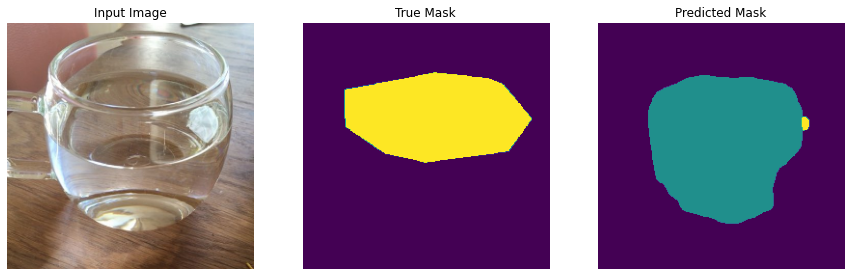

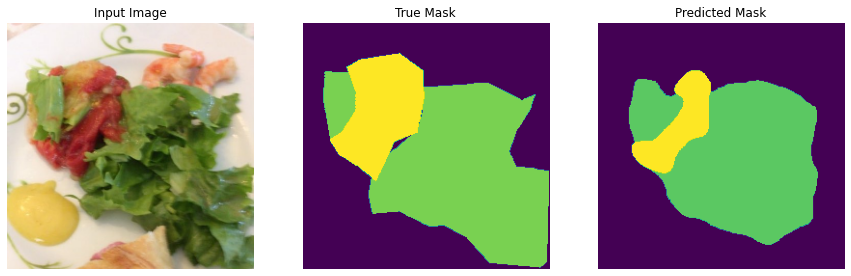

In [74]:
#Plotting a few random images of the validations set

np.random.seed(1)

val_images_ids = []
for className in classes:
    # get all images containing given categories
    catIds = coco_val.getCatIds(catNms=className)
    imgIds = coco_val.getImgIds(catIds=catIds)
    for i in imgIds:
        val_images_ids.append(i)

num_image_to_plot = 2
rand = np.random.randint(0, len(images_val), num_image_to_plot)

X = np.zeros((num_image_to_plot, input_image_size[0], input_image_size[1], 3))

ids = [] #store here selected image ids selected in a random way 
j = 0
for i in rand:
  ids.append(val_images_ids[i])
  img = coco_val.loadImgs(val_images_ids[i])[0]
  image = tf.io.read_file(folder_loc + '/val/images/' + img['file_name'])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, input_image_size)
  X[j] = image
  X[j] = X[j]/255.0
  j+=1
  

#Select images in order to get the true mask
images = []
for i in range(num_image_to_plot):
  for j in range(len(images_val)):
    if images_val[j]['id'] == ids[i]:
      images.append(images_val[j])

for i in range(len(X)):
  pred_mask = model.predict(X[i].reshape(1, input_image_size[0], input_image_size[1], 3))
  catIds = coco_val.getCatIds(catNms=classes)
  true_mask = getBinaryMask(images[i], classes, coco_val, catIds, input_image_size)
  display([X[i], plot_true_mask(true_mask), create_mask(pred_mask)])

Plot one binary mask per category showing model's predictions

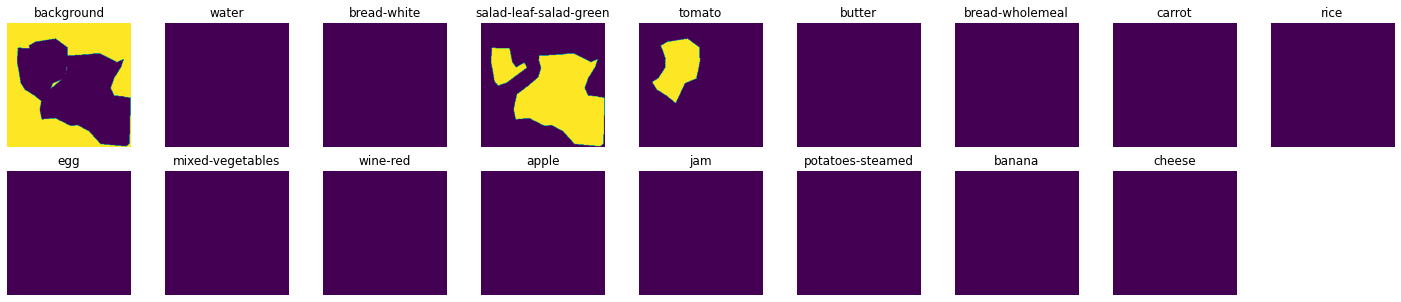

In [71]:
#TRUE BINARY MASKS
display_binary_masks(true_mask)

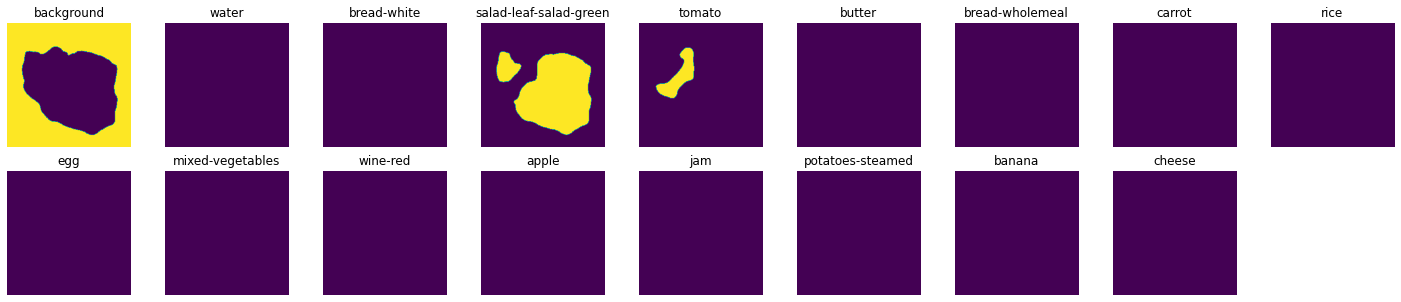

In [72]:
#PREDICTED BINARY MASKS
plot_predicted_masks(pred_mask)

## Model Evaluations

In [ ]:
def compute_metrics_single_image(true_mask, pred_mask):
  pred_mask[pred_mask >= 0.5] = 1
  pred_mask[pred_mask < 0.5] = 0
  #Using the IoU metric of the segmentation_models library
  iou_metric = sm.base.functional.iou_score(true_mask, pred_mask, backend = K)
  iou = np.round(iou_metric, decimals=2)
  
  true_mask = true_mask.reshape(1, input_image_size[0], input_image_size[1], number_of_classes)
  precision_metric = tf.keras.metrics.Precision()
  recall_metric = tf.keras.metrics.Recall()

  precision_metric.update_state(true_mask, pred_mask)
  precision = np.round(precision_metric.result(), decimals=2)
  
  recall_metric.update_state(true_mask, pred_mask)
  recall = np.round(recall_metric.result(), decimals=2)

  return iou, precision, recall

In [ ]:
def evaluation(model, data_gen):
  iou_scores = []
  precision_scores = []
  recall_scores = []  

  for i in range(dataset_size_val):
    img, true_mask = next(data_gen)
    pred_mask = model.predict(img)
    iou, precision, recall = compute_metrics_single_image(true_mask,pred_mask)
    iou_scores.append(iou)
    precision_scores.append(precision)
    recall_scores.append(recall)

  average_iou = np.mean(iou_scores)
  average_precision = np.mean(precision_scores)
  average_recall = np.mean(recall_scores)

  return average_iou, average_precision, average_recall

## Loading weights of different models and compare them

*   Loss function: multiclass weighted dice loss
*   Batch_size: 8



In [48]:
model.load_weights(folder_loc + '/models/linknet_dice_loss.hdf5')

In [ ]:
evaluation_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc, input_image_size, 1, 'val', mask_type)
average_iou, average_precision, average_recall = evaluation(model, evaluation_gen)

In [ ]:
print(f"Mean IoU = {average_iou:.2f}, Precision = {average_precision:.2f}, Recall = {average_recall:.2f}")

Mean IoU = 0.89, Precision = 0.77, Recall = 0.76


### Model 2

*   Loss function: multiclass weighted cross entropy
*   Batch_size: 8


In [45]:
model.load_weights(folder_loc + '/models/linknet_weights_crossentropy.hdf5')

In [46]:
evaluation_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc, input_image_size, 1, 'val', mask_type)
average_iou, average_precision, average_recall = evaluation(model, evaluation_gen)

In [47]:
print(f"Mean IoU = {average_iou:.2f}, Precision = {average_precision:.2f}, Recall = {average_recall:.2f}")

Mean IoU = 0.61, Precision = 0.60, Recall = 0.58


### Model 3

* Loss function: multiclass wighted squared dice loss
* Batch_size: 8

In [55]:
model.load_weights(folder_loc + '/models/Linknet_multi_weighted_squared_dice_loss.hdf5')

In [56]:
evaluation_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc, input_image_size, 1, 'val', mask_type)
average_iou, average_precision, average_recall = evaluation(model, evaluation_gen)

In [57]:
print(f"Mean IoU = {average_iou:.2f}, Precision = {average_precision:.2f}, Recall = {average_recall:.2f}")

Mean IoU = 0.87, Precision = 0.81, Recall = 0.71
